Поскольку у pymc3 какие-то проблемы с theano, на Colab пришлось поставить dev версию через github.

In [118]:
!pip install git+https://github.com/pymc-devs/pymc3 numpyro numpy pandas matplotlib seaborn arviz scipy

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-r5pduj8r
  Running command git clone -q https://github.com/pymc-devs/pymc3 /tmp/pip-req-build-r5pduj8r
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


Поскольку LaTex не стоит на колабовской машине, а нам хотелось бы его использовать и в графиках, поставим:

In [119]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
#! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
#! unzip type1cm.zip -d /tmp/type1cm 
#! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
#! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
#! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
#! sudo texhash 
#!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  lib

In [120]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
sns.set()
from scipy import stats

In [122]:
import jax.numpy as jnp
import jax
from jax import random, vmap
from jax.scipy.special import logsumexp

In [123]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

Вспомним формулу Байеса:
$$
p(\theta | x) = \dfrac{p(x | \theta)p(\theta)}{p(x)}
$$

Простой дискретный пример.

В Небольшом пруду водятся караси и щуки, причём согласно поверью, в любой момент времени доля карасей в Небольшом пруду может равновероятно быть либо $1/3$, либо $2/3$ в зависимости от погодных условий. Исследовательница Авдотья вылавливает десять рыб подряд. Оказалось, что в полученной выборке шесть щук и четыре карася.

а) Найдите оценку максимального правдоподобия $\hat{p}_{c}$, рассуждая с позиций частотного подхода.

Ответ: $\hat{p}_{c} = 4/10$

б) Сделаем то же самое в рамках байесовского подхода. 

$$ 
p(\theta | y)  \propto p(y| \theta) \times p(\theta)
$$

$ p(\theta) = 1/2 $ (оба значения доли карасей равновероятны), $ p(y| \theta) = p^x \times (1-p)^{n-x}$. Посчитаем апостериорное распределение для обоих возможных значений $p$: 

In [124]:
p1 = (1/3) ** 4 * (2/3) ** 6 * (1/2)
p2 = (2/3) ** 4 * (1/3) ** 6 * (1/2)
print(f"Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет {p1/(p1+p2)}.")
print(f"Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет {p2/(p1+p2)}.")

Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет 0.8.
Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет 0.2.


Это вполне логично - 0.4 ближе к 1/3, чем к 2/3. 

#### Задание 1. Караси и щуки.

В Большом пруду водятся караси и щуки, причём согласно поверью, вероятность встретить карася равномерно распределена на отрезке от 0 до 1. Ловля рыбы в Большом пруду запрещена, поэтому исследовательница Авдотья решает провести численный эксперимент для вывода апостериорного распределения вероятности встретить карася.

Сгенерируйте выборку из из 100 наблюдений, каждое из которых является идентификатором того, является ли пойманная рыба карасём.

In [125]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.31


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

1. Задайте вероятностную модель.

In [126]:
def model(y):
  p = numpyro.sample('share', dist.Uniform(0, 1))
  y_obs = numpyro.sample('obs', dist.Bernoulli(p), obs=y)

2. Оцените модель и получите приблизительное апостериорное распределение параметров.

In [127]:
kernel = NUTS(model) # NUTS sampler 
# 100 первых наблюдений будет выкинуто при оценке апостериорного распределения
# оставшиеся 500 наблюдений будут сохранены
mcmc = numpyro.infer.MCMC(kernel, num_warmup=100, num_samples=1000)
mcmc.run(random.PRNGKey(123), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:02<00:00, 380.20it/s, 3 steps of size 9.44e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     share      0.32      0.05      0.31      0.24      0.39    266.06      1.01

Number of divergences: 0


In [128]:
print(f"Выборочное среднее апостериорного распределения: {samples_1['share'].mean()}.")

Выборочное среднее апостериорного распределения: 0.31555771827697754.


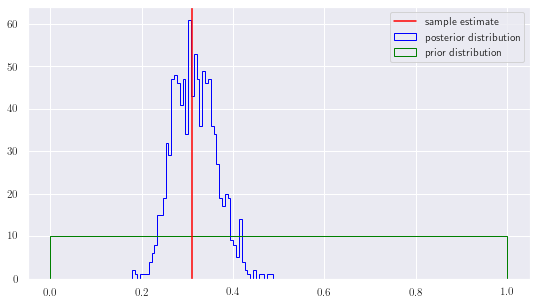

In [129]:
plt.figure(figsize=(9, 5));
plt.hist(samples_1['share'], bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');


У `numpyro` заметно сразу два минуса:
* Нельзя нарисовать динамику по цепям для генерируемого апостериорного распределения.
* Не считаются никакие статистики, которые говорили бы о сходимости апостериорного распределения. В этом плане `PyMC3` гораздо лучше.

Попробуем то же самое сделать через PyMC3, благо синтаксис похож.

In [130]:
ndraws = 1000
nburn = 100

with pm.Model() as model:
  p = pm.Uniform('p', lower=0, upper=1)
  y_obs = pm.Bernoulli('obs', p=p, observed=y)

  step = pm.NUTS()
  trace = pm.sample(# сколько наблюдений мы хотим сэмплировать
                    ndraws,
                    # сколько наблюдений мы хотим "сжечь"
                    tune=nburn, 
                    # удаляем ли мы "сжигаемые" набл-я из апостериорной выборки
                    discard_tuned_samples=True, 
                    # сэмплировщик
                    step=step, 
                    random_seed=np.random.seed(123),
                    # количество ядер, чтоб считать параллельно
                    cores=4,
                    # количество цепей Маркова
                    chains=4)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9364867742202131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9250555712099223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985671977640293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9448217192976814, but should be close to 0.8. Try to increase the number of tuning steps.


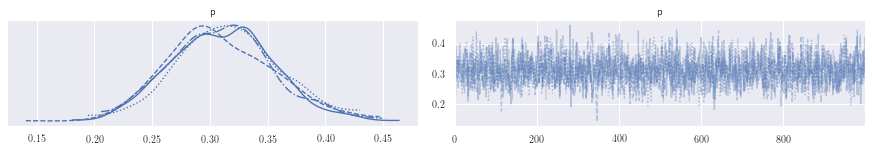

In [131]:
az.plot_trace(trace);

В `trace` есть много чего, при желании можно вытащить, например, выборку из апостериорного распределения для каждой цепи. 

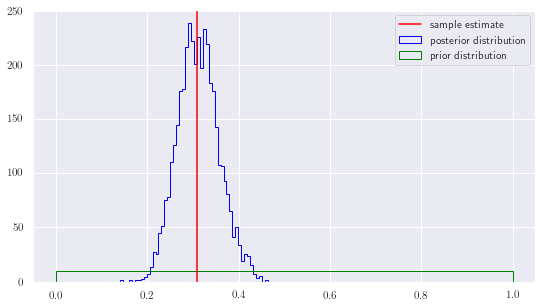

In [132]:
plt.figure(figsize=(9, 5));
plt.hist(np.array(trace.posterior.p).ravel(), bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');

Попробуем вытащить характеристики апостериорного распределения:

In [133]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.312,0.045,0.228,0.398,0.001,0.001,1652.0,2187.0,1.0


In [134]:
print(f"Выборочное среднее апостериорного распределения: {np.array(trace.posterior.p).ravel().mean()}.")

Выборочное среднее апостериорного распределения: 0.3116395668139771.


Посмотрим, удалились ли те наблюдения из апостериорного распределения, которые мы хотели сжечь. Если да, то shape у trace.posterior.p = (4, 1000).

In [135]:
np.array(trace.posterior.p).shape

(4, 1000)

#### Задание 2. Структурный сдвиг.

In [136]:
years = np.arange(1800, 2000)
casual_1 = stats.poisson(3).rvs(100)
casual_2 = stats.poisson(1).rvs(100)
casualties = np.hstack((casual_1, casual_2))

In [137]:
df = pd.DataFrame({'year': years, 'casualties': casualties})

In [138]:
plt.figure(figsize=(11, 5));
plt.plot(df.year, df.casualties, 'o', alpha=0.4, markersize=8);
plt.title('Распределение числа аварий на шахтах');
plt.axvline(1900, color='red');
plt.text(1910, 6, 'Структурный сдвиг: 1900?', bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2e0599d560> (for post_execute):


RuntimeError: ignored

RuntimeError: ignored

<Figure size 792x360 with 1 Axes>

Будем считать, что авариина шахте распределены по Пуассону и независимы:
$x_i \sim \mathrm{Pois}(\lambda)$, где

$$
\lambda = \begin{cases}
\lambda_1, t < \tau, \\
\lambda_2, t \ge \tau
\end{cases}
$$

Априорное распределение $\lambda$: $\lambda \sim \mathrm{Exp}(\alpha)$, где $alpha$ - некоторый гиперпараметр, который мы не знаем.

Оценим $\alpha$ на основе выборки:

In [139]:
y = casualties
alpha = 1 / np.mean(y)
alpha

0.4938271604938272

In [140]:
with pm.Model() as DisasterModel:
  # априорные распределения параметров
  tau = pm.DiscreteUniform("tau", lower=years.min(), upper=years.max())

  early_rate = pm.Exponential("early_rate", alpha)
  late_rate = pm.Exponential("late_rate", alpha)

  # разные значения alpha в зависимости от tau
  rate = pm.math.switch(tau>=years, early_rate, late_rate)

  # связь y c rate
  y_obs = pm.Poisson('disasters', rate, observed=y)

In [141]:
n_draws = 1000
n_burn = 100

with DisasterModel:
  sample = pm.sample(draws=n_draws,
                     tune=n_burn,
                     chains=4, 
                     cores=4, 
                     random_seed=np.random.seed(123))

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [tau]
INFO:pymc3:>Metropolis: [tau]
>NUTS: [early_rate, late_rate]
INFO:pymc3:>NUTS: [early_rate, late_rate]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 7 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9162600357038817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9233355063294989, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9304968102461382, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9251033358191207, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not con

In [142]:
az.plot_trace(sample);

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2e0599d560> (for post_execute):


RuntimeError: ignored

RuntimeError: ignored

<Figure size 864x432 with 6 Axes>

In [143]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1882.093,15.213,1860.000,1900.000,6.625,4.974,6.0,67.0,1.66
early_rate,3.028,0.193,2.691,3.404,0.003,0.002,3116.0,2527.0,1.01
late_rate,1.291,0.241,0.906,1.694,0.096,0.072,7.0,123.0,1.54


In [144]:
plt.figure(figsize=(7, 5));
plt.hist(np.array(sample.posterior.tau).ravel(), bins=50);
plt.title('Распределение значения года для структурного сдвига');


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2e0599d560> (for post_execute):


RuntimeError: ignored

RuntimeError: ignored

<Figure size 504x360 with 1 Axes>

Оценим вероятность того, что $\lambda_i$ различны:

In [145]:
np.mean(np.array(sample.posterior.early_rate) - \
        np.array(sample.posterior.late_rate) > 0)

1.0

### Байесовская линейная регрессия.

Набор данных - WaffleDivorce, содержащий информацию о проценте разводов в 50 штатах США.

In [146]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
df = pd.read_csv(DATASET_URL, sep=';')
df.head(5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


Нам предлагаются следующие признаки для анализа:

* `Population`
* `MedianAgeMarriage`
* `Marriage`
* `WaffleHouses`
* `South`.

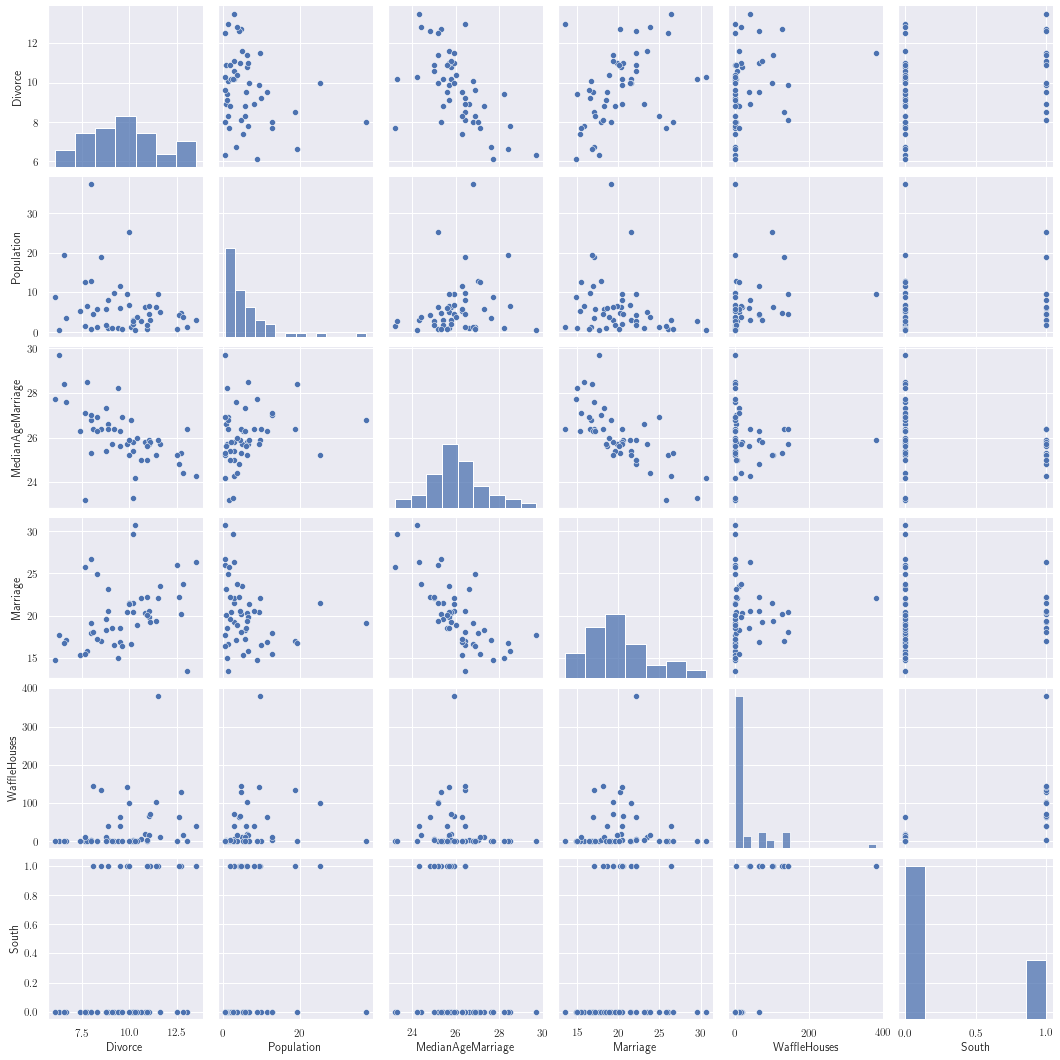

In [147]:
regr = ['Divorce', 'Population', 'MedianAgeMarriage', 'Marriage',
        'WaffleHouses', 'South']
sns.pairplot(df, x_vars=regr, y_vars=regr);

Хорошая корреляция у `Divorce` есть только с `MedianAgeMarriage` и `Marriage`, и ещё слабая с `WaffleHouses`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


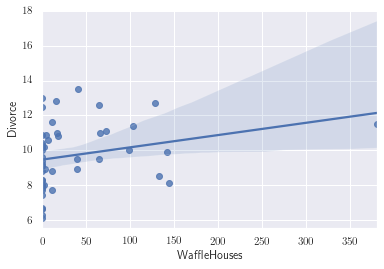

In [148]:
sns.regplot('WaffleHouses', 'Divorce', df);

Скорее всего, корреляция с числом ресторанов в штате ложная - вряд ли этот фактор как-то влияет на процент разводов.

In [149]:
X = df[['Divorce', 'Marriage', 'MedianAgeMarriage']]

In [150]:
stand = lambda x: (x-x.mean()) / x.std()
X = X.apply(stand)

Модель:

$$ \mathrm{divorce} \sim \mathcal{N}(\mu, \sigma^2). $$$$ \mu = \beta_0 + \beta_1\mathrm{marriage} + \beta_2\mathrm{age}. $$

Иначе говоря, мы подразумеваем нормальность ошибки.

In [151]:
#  случайными у нас будут коэффициенты, три переменные и сигма
def model(divorce=None, marriage=None, age=None):
  beta0 = numpyro.sample('beta0', dist.Normal(0, 0.2))
  MARRIAGE, AGE = 0, 0

  # ифы сделаны, чтобы можно было добавлять разные регрессоры в модель
  if marriage is not None:
    beta1 = numpyro.sample('beta1', dist.Normal(0, 0.5))
    MARRIAGE = beta1 * marriage

  if age is not None:
    beta2 = numpyro.sample('beta2', dist.Normal(0, 0.5))
    AGE = beta2 * age

  sigma = numpyro.sample('sigma', dist.Exponential(1))
  mu = beta0 + MARRIAGE + AGE
  numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

Используем в качестве регрессора только `marriage`:

In [152]:
kernel = NUTS(model)
mcmc = MCMC(sampler=kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(random.PRNGKey(0), 
         marriage=X['Marriage'].values,
         divorce=X['Divorce'].values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 6719.06it/s, 3 steps of size 7.36e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.00      0.11     -0.00     -0.19      0.18   7587.82      1.00
     beta1      0.35      0.13      0.35      0.12      0.55   7265.98      1.00
     sigma      0.95      0.10      0.94      0.80      1.11   6682.60      1.00

Number of divergences: 0


In [153]:
trace_df = pd.DataFrame({'beta0': np.array(samples_1['beta0']),
                         'beta1': np.array(samples_1['beta1']),
                         'sigma': np.array(samples_1['sigma'])})

In [157]:
#plt.rc('text', usetex=True)

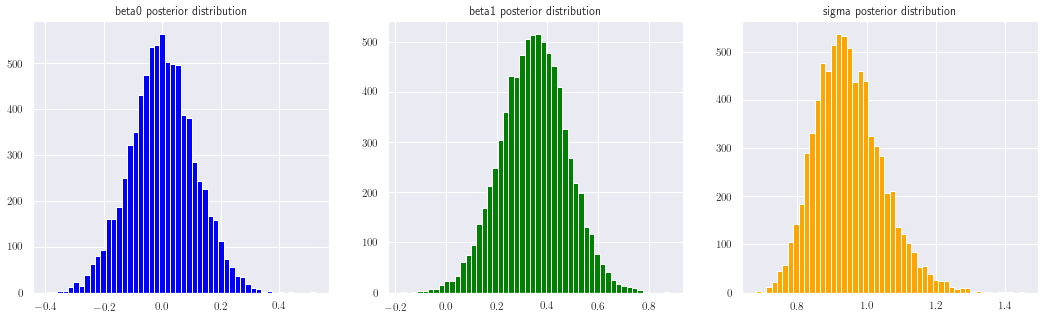

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax[0].hist(trace_df.beta0, bins=50, color='blue')
ax[0].set_title('beta0 posterior distribution')
ax[1].hist(trace_df.beta1, bins=50, color='green')
ax[1].set_title('beta1 posterior distribution')
ax[2].hist(trace_df.sigma, bins=50, color='orange')
ax[2].set_title('sigma posterior distribution')

fig.show();

Видно, что intercept равен нулю, в то время как коэффициеет при marriage положительный. С оценкой $\sigma$ мы удачно угадали.

[Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 0, 'Marriage rate'),
 Text(0.5, 1.0, 'Regression line with 95% CI')]

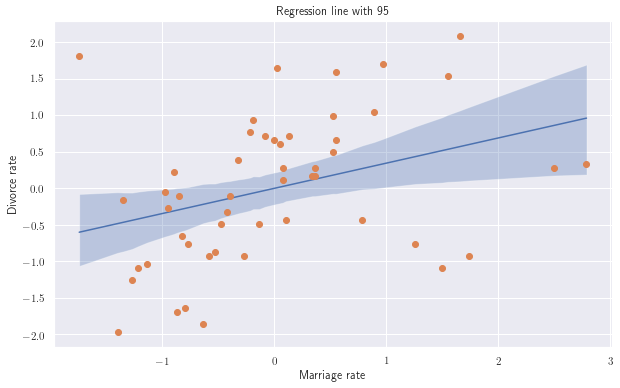

In [165]:
def plot_regression(x, y_mean, y_hpdi):
  # sort values for plotting by x axis
  idx = jnp.argsort(x)
  marriage = x[idx]
  mean = y_mean[idx]
  hpdi = y_hpdi[:, idx]
  divorce = X['Divorce'].values[idx]

  #Plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
  ax.plot(marriage, mean)
  ax.plot(marriage, divorce, 'o')
  ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
  return ax

# compute empirical posterior over mu
posterior_mu = jnp.expand_dims(samples_1['beta0'], -1) + \
               jnp.expand_dims(samples_1['beta1'], -1) * \
               X['Marriage'].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)
ax = plot_regression(X['Marriage'].values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', 
         title='Regression line with 95% CI')



Собственно, здесь видно преимущество байесовского подхода: доверительный интервал гибкий, он учитывает распределение параметров и потому нелинеен.